In [1]:
# basic stuff 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# from google.colab import files
import os
import sklearn
import time
import math
import itertools

# torch stuff
import torch
from torch import nn
import torch.nn.functional as F

# !pip install mat73
# import mat73

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import sys
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/PopFRData/')
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/xds_python/')
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/custom_functions/')

from xds import lab_data
import joint_angles
import data_loading
import train_test
from train_test import train, test
import r2_pr2
import pr2
import models
from models import TempConvNet, FCNet
import visualization

Load datasets

In [4]:
tcnn_dataset_dict_fr = data_loading.load_datasets('/content/drive/My Drive/Miller_Lab/FIU/PopFRData/tcnn_processed_shuffled_opensim_datasets/instance_length_100/fullyrestrained')
tcnn_loader_dict_fr = data_loading.get_loaders(tcnn_dataset_dict_fr, 32)

In [5]:
dates_list = ['20210710','20210712','20210814','20211105','20220309','20220224','20210928','20220210pipe','20220210uc','20211208pipe','20211208uc','20211207pipe','20211207uc','20211209']

In [6]:
good_datasets_dict = {date:tcnn_dataset_dict_fr[date] for date in dates_list}
good_loaders_dict = {date:tcnn_loader_dict_fr[date] for date in dates_list}

In [12]:
a = np.array(list(good_datasets_dict.keys()))

In [48]:
dates = np.array(list(good_datasets_dict.keys()))
all_perms = [dates]
for i in range(5):
    arr = np.arange(len(dates_list))
    np.random.shuffle(arr)
    all_perms.append(dates[arr])

In [49]:
all_perms

[array(['20210710', '20210712', '20210814', '20211105', '20220309',
        '20220224', '20210928', '20220210pipe', '20220210uc',
        '20211208pipe', '20211208uc', '20211207pipe', '20211207uc',
        '20211209'], dtype='<U12'),
 array(['20211209', '20211207pipe', '20211105', '20220309', '20211207uc',
        '20220210uc', '20210710', '20220224', '20210814', '20210928',
        '20210712', '20211208uc', '20211208pipe', '20220210pipe'],
       dtype='<U12'),
 array(['20220210pipe', '20220224', '20210814', '20220309', '20211209',
        '20211105', '20211207pipe', '20220210uc', '20211208pipe',
        '20211208uc', '20210928', '20210710', '20210712', '20211207uc'],
       dtype='<U12'),
 array(['20211208pipe', '20220309', '20220210pipe', '20211105',
        '20211207uc', '20210710', '20211209', '20210814', '20210928',
        '20211207pipe', '20220210uc', '20211208uc', '20210712', '20220224'],
       dtype='<U12'),
 array(['20220309', '20211207uc', '20211208uc', '20220210uc', '2022

In [50]:
def plot_losses_transfer_learning_TCN(dataset_dict, loader_dict, num_permutations, init_lr, lr_factor, save = True, num_conv_layers = 3,  num_epochs = 101, restraint_type = 'fullyrestrained'):
    '''
    Trains multiple TCNs in transfer learning. The model is trained in the following way:
    
    A set of random permutations of dates and splits is created.
    All permutations for the splits are flattened into a list - since I made 3 splits, this makes a list of 18 integers.
    A subset of 18 permutations for dates is chosen.
    The learning rate begins at init_lr for all layers, and then decreased for the core of the model (i.e. the convolutional layers) by a factor of lr_factor each time the split number changes.
    The transfer layer is alwyas trained with an initial learning rate of init_lr.

    Below is an example of how the models are trained:
        Split 0, Date Permutation 0 (e.g. '20210712', '20220309', '20210710', '20211105', '20210814'), transfer layer lr = 0.001, core initial learning rate = 0.001
        Split 1, Date Permutation 1 (e.g. '20210710', '20211105', '20210814', '20210712', '20220309'), transfer layer lr = 0.001, core initial learning rate = 0.001*lr_factor
        Split 2, Date Permutation 2 (e.g. '20210814', '20210712', '20220309', '20210710', '20211105'), transfer layer lr = 0.001, core initial learning rate = 0.001*(lr_factor^2)
        Split 1, Date Permutation 3 (e.g. '20220309', '20210712', '20211105', '20210710', '20210814'), transfer layer lr = 0.001, core initial learning rate = 0.001*(lr_factor^3)
        Split 2, Date Permutation 3 (e.g. '20211105', '20210710', '20210712', '20210814', '20220309'), transfer layer lr = 0.001, core initial learning rate = 0.001*(lr_factor^4)
        Split 0, Date Permutation 3 (e.g. '20220309', '20211105', '20210814', '20210712', '20210710'), transfer layer lr = 0.001, core initial learning rate = 0.001*(lr_factor^5)
        etc...
    After 18 rounds, the final learning rate for the core layers is 0.001*(lr_factor^18). For lr_factor = 0.7, this equates to 1.6e-6.

    Args:
        dataset_dict (dict): a dictionary containing datasets that are split by electrode.
        loader_dict (dict): a dictionary containing train and test loaders that are also split by electrode.
        init_lr (float): the initial learning rate for the convolutional layers.
        lr_factor (float): the factor by which the initial learning rate is decayed every permutation.
        num_epochs (int): number of epochs each model is trained each permutation.

    Returns:
        A dictionary containing all the models for each date/split.
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dates = np.array(list(dataset_dict.keys()))
    all_perms = [dates]
    for i in range(5):
        arr = np.arange(len(dates_list))
        np.random.shuffle(arr)
        all_perms.append(dates[arr])

    losses = {'All Losses': {},'By Dataset': {}}
    losses['All Losses'][lr_factor] = {'Train': [], 'Test': []}
    losses['By Dataset'][lr_factor] = {'Train': {},'Test': {}}
    for date in loader_dict.keys():
        for train_test_str in losses['By Dataset'][lr_factor].keys():
            losses['By Dataset'][lr_factor][train_test_str][date] = []

    models = {}
    for date in dataset_dict.keys():
        models[date] = {}
        for input_type in dataset_dict[date].keys():
            models[date][input_type] = {}
    
    date0 = all_perms[0][0]
    output_dim = dataset_dict[date0]['Joint Angles']['Full'].num_neural_units
    model = TempConvNet(24, output_dim, num_conv_layers, 1, 5, 2, add_relu = True, causal=True).to(device)

    # get randomly initialized linear layers
    linear_layers = {}
    for date in dataset_dict.keys():
        output_dim = dataset_dict[date]['Joint Angles']['Full'].num_neural_units
        m = TempConvNet(24, output_dim, num_conv_layers, 1, 5, 2, add_relu = True, causal=True).to(device)
        linear_layers[date] = m.net[-2]

    c = -1
    for iteration, perm in enumerate(all_perms):
        for i, date in enumerate(perm):
            c+=1
            model.net[-2] = linear_layers[date]

            train_loader, test_loader, full_dataset = \
                loader_dict[date]['Joint Angles']['Train'], \
                loader_dict[date]['Joint Angles']['Test'], \
                dataset_dict[date]['Joint Angles']['Full']

            print(date,full_dataset.num_neural_units)

            lr = init_lr*(lr_factor**(c))
            criterion = torch.nn.MSELoss()
            optimizer = torch.optim.Adam([
                {'params': model.net[0].parameters(), 'lr': lr},
                {'params': model.net[2].parameters(), 'lr': lr},
                {'params': model.net[4].parameters(), 'lr': lr},
                {'params': model.net[6].parameters(), 'lr': 0.001}])
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=8, min_lr=0.0)   
            total_params = sum(p.numel() for p in model.parameters())

            print('Date: {}, Initial LR: {} '.format(date,lr))
            print('Num Conv Layers: {}, Total Parameters: {}'\
                .format(model.num_conv_layers, total_params))

            start = time.time()
            for epoch in range(num_epochs):
                lr = scheduler.optimizer.param_groups[0]['lr']
                train_loss = train(train_loader, model, optimizer, criterion, scheduler, conv = True)
                _, train_R2, train_pr2, train_preds, train_targets = test(train_loader, model, optimizer, criterion, full_dataset.num_neural_units, conv = True)
                test_loss, test_R2, test_pr2, test_preds, test_targets = test(test_loader, model, optimizer, criterion, full_dataset.num_neural_units, conv = True)
                scheduler.step(test_loss)
                if epoch % 50==0:
                  print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:7f}, Test Loss: {:7f}. Train R2: {:.7f}, Test R2: {:.7f}, Train pR2: {:.7f}, Test pR2: {:.7f}'\
                      .format(epoch, lr, train_loss, test_loss, train_R2, test_R2, train_pr2, test_pr2))

                losses['All Losses'][lr_factor]['Train'].append(train_loss)
                losses['All Losses'][lr_factor]['Test'].append(test_loss)
                losses['By Dataset'][lr_factor]['Train'][date].append(train_loss)
                losses['By Dataset'][lr_factor]['Test'][date].append(test_loss)

            end = time.time()
            print('Time to train model: {}'.format(end-start))
            plt.plot(losses['By Dataset'][lr_factor]['Train'][date])
            plt.plot(losses['By Dataset'][lr_factor]['Test'][date])
            plt.title('Losses - Date: {}, Num Conv Layers: {}'.format(date, model.num_conv_layers))
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend(['Train Losses', 'Test Losses'])
            plt.show()

            # replace linear layer with most recently trained
            linear_layers[date] = model.net[-2]

            models[date]['Joint Angles'] = model

            if iteration == num_permutations-1:
                directory = '/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/Pop_FR_OpenSIM/TransferLearning/NonSplit/{}/'.format(restraint_type)
                model_name = 'TempCNN_{}_{}_convlayers_reluadded'.format(date, num_conv_layers)
                if save == True:
                    if os.path.exists(directory) == False:
                        os.makedirs(directory)
                    torch.save(model.state_dict(), directory+model_name)
    return(models)

In [53]:
models = plot_losses_transfer_learning_TCN(good_datasets_dict, good_loaders_dict, 6, 0.001, 0.95, 
                                          save = True, num_conv_layers = 4,  num_epochs = 101, restraint_type = 'fullyrestrained')

Output hidden; open in https://colab.research.google.com to view.

In [52]:
models = plot_losses_transfer_learning_TCN(good_datasets_dict, good_loaders_dict, 6, 0.001, 0.95, 
                                          save = True, num_conv_layers = 3,  num_epochs = 101, restraint_type = 'fullyrestrained')

Output hidden; open in https://colab.research.google.com to view.

## Plotting distributions

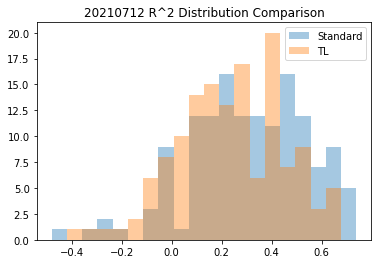

In [ ]:
standard_dist = plt.hist(r2_20210712, label = 'Standard', alpha = 0.4, bins = 20)
plt.hist(r2_20210712_tl, label = 'TL', alpha = 0.4, bins = standard_dist[1])
plt.legend()
plt.title('20210712 R^2 Distribution Comparison')
plt.show()